In [19]:
#this enviornment is LLM
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torchvision
import gc
import math
import os

In [20]:
# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数设置
latent_dim = 100  # 潜在空间的维度
batch_size = 512
lr = 0.0008
num_epochs = 25
image_size = 64
channels = 1  # 图像通道数，对于彩色图像使用3

In [21]:
# 图像预处理
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 加载数据
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [22]:
# 生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()  # 使用Tanh作为输出层激活函数
        )

    def forward(self, z):
        return self.model(z)

# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)


In [23]:
# 初始化生成器和判别器
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 优化器
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


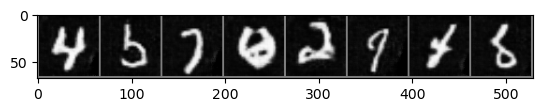

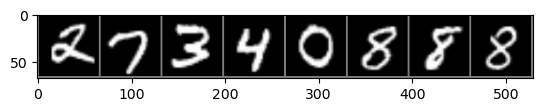

Epoch [25/25] Batch [118/118] Loss D: 0.13993945717811584, loss G: 1.971404790878296
Epoch [25/25]  AVG_Loss D: 0.1220517689875185, AVG_loss G: 5.060466925471516


In [24]:
def imshow(img1, img2):
    img1 = torchvision.utils.make_grid(img1)
    img2 = torchvision.utils.make_grid(img2)

    image1 = img1 / 2 + 0.5     # unnormalize
    image2 = img2 / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    npimg1 = image1.detach().numpy()
    npimg2 = image2.detach().numpy()
    #print(npimg.shape)
    plt.imshow(np.transpose(npimg1, (1, 2, 0)))
    plt.show()
    #plt.pause(0.005)
    plt.imshow(np.transpose(npimg2, (1, 2, 0)))
    plt.show()
    plt.pause(0.005)
    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # 绘制第一个图像 (假图像)
    grid_fake = torchvision.utils.make_grid(img1)
    axs[0].imshow(grid_fake.permute(1, 2, 0).numpy())
    axs[0].set_title("Fake Images")
    axs[0].axis('off')  # 隐藏坐标轴

    # 绘制第二个图像 (真实图像)
    grid_real = torchvision.utils.make_grid(img2)
    axs[1].imshow(grid_real.permute(1, 2, 0).numpy())
    axs[1].set_title("Real Images")
    axs[1].axis('off')  # 隐藏坐标轴

    plt.show()
    '''

for epoch in range(num_epochs):
    correct = 0
    total = 0
    #running_loss = 0.0
    total_dloss = 0.0
    total_gloss = 0.0
    for i, (imgs, _) in enumerate(train_loader):
        clear_output(wait=True)
        #print(len(train_loader))
        
        # 真实图像和假图像的训练
        real_imgs = imgs.to(device)
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        optimizer_D.zero_grad()
        #print(discriminator(real_imgs).shape)
        #print(discriminator(fake_imgs.detach()).shape)
        size_r = len(discriminator(real_imgs).detach().numpy())
        size_f = len(discriminator(fake_imgs).detach().numpy())
        #print(size)
        #print(torch.ones(size_r).shape)
        #print(torch.ones(size_f).shape)
        real_loss = nn.functional.binary_cross_entropy(discriminator(real_imgs), torch.ones(size_r).to(device))
        fake_loss = nn.functional.binary_cross_entropy(discriminator(fake_imgs.detach()), torch.zeros(size_f).to(device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        total_dloss += d_loss.item()

        # 训练生成器
        optimizer_G.zero_grad()
        g_loss = nn.functional.binary_cross_entropy(discriminator(fake_imgs), torch.ones(size_f).to(device))
        g_loss.backward()
        optimizer_G.step()

        total_gloss += g_loss.item()
        fake_imgs = fake_imgs[:8]
        real_imgs = real_imgs[:8]
        imshow(fake_imgs, real_imgs)
        #imshow(torchvision.utils.make_grid(real_imgs))

        del real_imgs, fake_imgs
        torch.cuda.empty_cache()
        gc.collect() 
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i+1}/{len(train_loader)}] Loss D: {d_loss.item()}, loss G: {g_loss.item()}")
    print(f"Epoch [{epoch+1}/{num_epochs}]  AVG_Loss D: {total_dloss/len(train_loader)}, AVG_loss G: {total_gloss/len(train_loader)}")
